In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Add, Concatenate, Dense, Dropout,
                                     Multiply, Reshape)
import os, kagglehub

# Disable XLA JIT (to avoid huge pinned‐host allocs)
tf.config.optimizer.set_jit(False)

# GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(" GPU memory growth enabled")
else:
    print(" No GPU detected")

mixed_precision.set_global_policy('mixed_float16')
print(" Mixed precision policy:", mixed_precision.global_policy())


 GPU memory growth enabled
 Mixed precision policy: <DTypePolicy "mixed_float16">


In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download("nafishamoin/bangladeshi-crops-disease-dataset")
print(" Raw dataset path:", path)

main_folder = os.listdir(path)[0]
main_path = os.path.join(path, main_folder)
print(" Main folder:", main_folder)
print("Contents of main folder:", os.listdir(main_path)[:5])

image_root = os.path.join(main_path, "Crop___DIsease")
print(" Image root folder:", image_root)

classes = os.listdir(image_root)
print(" Classes found:", classes[:10])

 Raw dataset path: /kaggle/input/bangladeshi-crops-disease-dataset
 Main folder: CropDisease
Contents of main folder: ['Crop___DIsease']
 Image root folder: /kaggle/input/bangladeshi-crops-disease-dataset/CropDisease/Crop___DIsease
 Classes found: ['Wheat___Yellow_Rust', 'Potato___Healthy', 'Corn___Healthy', 'Wheat___Brown_Rust', 'Corn___Gray_Leaf_Spot', 'Rice___Brown_Spot', 'Wheat___Healthy', 'Rice___Leaf_Blast', 'Potato___Late_Blight', 'Rice___Healthy']


In [ ]:
data_root = os.path.join(main_path, "Crop___DIsease")

In [ ]:
#Load datasets with one hot labels
import tensorflow as tf

batch_size = 8
img_size   = (160, 160)

dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical' # yields one-hot float32 labels
)
dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Train element spec:", dataset_train.element_spec)

Found 31053 files belonging to 15 classes.
Using 24843 files for training.
Found 31053 files belonging to 15 classes.
Using 6210 files for validation.
Train element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))


In [ ]:
#Preprocessing pipeline (normalize + minimal prefetch)
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    dataset_train
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(500)
    .prefetch(1)
)

val_ds = (
    dataset_val
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(1)
)


In [ ]:
#Model building blocks
def simple_attention(x, reduction_ratio=8):
    c = x.shape[-1]
    gap = GlobalAveragePooling2D()(x)
    gap = Reshape((1,1,c))(gap)
    a = Dense(c//reduction_ratio, activation='relu')(gap)
    a = Dense(c, activation='sigmoid')(a)
    return Multiply()([x,a])

def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters,3,strides=stride,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x); x=Activation('relu')(x)
    x = Conv2D(filters,3,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    if stride!=1 or shortcut.shape[-1]!=filters:
        shortcut = Conv2D(filters,1,strides=stride,use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x,shortcut]); return Activation('relu')(x)

def residual_block_group(x, f, n, stride=1):
    x = residual_block(x,f,stride)
    for _ in range(1,n):
        x = residual_block(x,f,1)
    return x

def dense_block(x, layers_n, g_rate):
    feats = [x]
    for _ in range(layers_n):
        y = Concatenate()(feats)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(4*g_rate,1,padding='same',use_bias=False)(y)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(g_rate,3,padding='same',use_bias=False)(y)
        feats.append(y)
    return Concatenate()(feats)

def transition_layer(x):
    x = BatchNormalization()(x)
    x = Conv2D(x.shape[-1]//2,1,padding='same',use_bias=False)(x)
    return AveragePooling2D(2,2)(x)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks, optimizers, losses
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, Concatenate)
import os
from google.colab import drive



# Build DeReFNet
def build_derefnet(input_shape=(160,160,3), num_classes=dataset_train.cardinality().numpy(), growth_rate=12):
    i = Input(shape=input_shape)

    # Residual stream
    x = Conv2D(32, 3, padding='same', use_bias=False)(i)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    r1 = residual_block_group(x, 64, 1)
    r2 = residual_block_group(r1, 128, 1, stride=2)
    r3 = residual_block_group(r2, 256, 1, stride=2)
    a3 = simple_attention(r3); g3 = GlobalAveragePooling2D()(a3)
    gaps = [GlobalAveragePooling2D()(simple_attention(r)) for r in (r1, r2, r3)]

    # Dense stream
    d = Conv2D(32, 3, padding='same', use_bias=False)(i)
    d = BatchNormalization()(d); d = Activation('relu')(d); d = MaxPooling2D(2)(d)
    d = dense_block(d, 3, growth_rate); d = transition_layer(d)
    d = dense_block(d, 3, growth_rate); d = transition_layer(d)
    d = dense_block(d, 5, growth_rate); gd = GlobalAveragePooling2D()(d)

    # Fuse & classify
    f = Concatenate()([g3, gd, *gaps]); f = Dropout(0.5)(f)
    out = Dense(dataset_train.element_spec[1].shape[-1], activation='softmax', dtype='float32')(f)

    return Model(i, out)

# Learning rate schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Build and compile the model
model = build_derefnet()
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Path to save best model
model_path = '/content/drive/MyDrive/best/BNG_crops/best_model.h5'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Callbacks
cbs = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=4,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    callbacks.ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
]


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=cbs
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6921 - loss: 0.9662
Epoch 1: val_accuracy improved from -inf to 0.89823, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 354s 79ms/step - accuracy: 0.6921 - loss: 0.9661 - val_accuracy: 0.8982 - val_loss: 0.3080
Epoch 2/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8675 - loss: 0.3847
Epoch 2: val_accuracy improved from 0.89823 to 0.92963, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 219s 63ms/step - accuracy: 0.8675 - loss: 0.3847 - val_accuracy: 0.9296 - val_loss: 0.2029
Epoch 3/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8920 - loss: 0.3016
Epoch 3: val_accuracy did not improve from 0.92963
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 209s 60ms/step - accuracy: 0.8920 - loss: 0.3016 - val_accuracy: 0.9287 - val_loss: 0.1918
Epoch 4/30
3105/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9030 - loss: 0.2650
Epoch 4: val_accuracy improved from 0.92963 to 0.93607, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 219s 63ms/step - accuracy: 0.9030 - loss: 0.2650 - val_accuracy: 0.9361 - val_loss: 0.1772
Epoch 5/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9109 - loss: 0.2461
Epoch 5: val_accuracy improved from 0.93607 to 0.94267, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 215s 62ms/step - accuracy: 0.9109 - loss: 0.2461 - val_accuracy: 0.9427 - val_loss: 0.1530
Epoch 6/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9162 - loss: 0.2280
Epoch 6: val_accuracy did not improve from 0.94267
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 260s 61ms/step - accuracy: 0.9162 - loss: 0.2280 - val_accuracy: 0.9411 - val_loss: 0.1520
Epoch 7/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9200 - loss: 0.2136
Epoch 7: val_accuracy improved from 0.94267 to 0.94605, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 220s 64ms/step - accuracy: 0.9200 - loss: 0.2136 - val_accuracy: 0.9461 - val_loss: 0.1444
Epoch 8/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9237 - loss: 0.2054
Epoch 8: val_accuracy did not improve from 0.94605
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 216s 62ms/step - accuracy: 0.9237 - loss: 0.2054 - val_accuracy: 0.9459 - val_loss: 0.1455
Epoch 9/30
3105/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9243 - loss: 0.1999
Epoch 9: val_accuracy improved from 0.94605 to 0.94654, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 219s 63ms/step - accuracy: 0.9243 - loss: 0.1999 - val_accuracy: 0.9465 - val_loss: 0.1463
Epoch 10/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9279 - loss: 0.1977
Epoch 10: val_accuracy improved from 0.94654 to 0.94750, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 223s 65ms/step - accuracy: 0.9279 - loss: 0.1977 - val_accuracy: 0.9475 - val_loss: 0.1444
Epoch 11/30
3105/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9314 - loss: 0.1849
Epoch 11: val_accuracy did not improve from 0.94750
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 221s 64ms/step - accuracy: 0.9314 - loss: 0.1849 - val_accuracy: 0.9475 - val_loss: 0.1411
Epoch 12/30
3105/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9282 - loss: 0.1896
Epoch 12: val_accuracy improved from 0.94750 to 0.94767, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 217s 62ms/step - accuracy: 0.9282 - loss: 0.1896 - val_accuracy: 0.9477 - val_loss: 0.1440
Epoch 13/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9302 - loss: 0.1892
Epoch 13: val_accuracy improved from 0.94767 to 0.94911, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 218s 63ms/step - accuracy: 0.9302 - loss: 0.1892 - val_accuracy: 0.9491 - val_loss: 0.1415
Epoch 14/30
3105/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9330 - loss: 0.1856
Epoch 14: val_accuracy improved from 0.94911 to 0.94976, saving model to /content/drive/MyDrive/best/BNG_crops/best_model.h5


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 263s 63ms/step - accuracy: 0.9330 - loss: 0.1856 - val_accuracy: 0.9498 - val_loss: 0.1400
Epoch 15/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1787
Epoch 15: val_accuracy did not improve from 0.94976
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 218s 63ms/step - accuracy: 0.9332 - loss: 0.1787 - val_accuracy: 0.9493 - val_loss: 0.1419
Epoch 16/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9331 - loss: 0.1797
Epoch 16: val_accuracy did not improve from 0.94976
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 259s 62ms/step - accuracy: 0.9331 - loss: 0.1797 - val_accuracy: 0.9498 - val_loss: 0.1399
Epoch 17/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9336 - loss: 0.1786
Epoch 17: val_accuracy did not improve from 0.94976
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 264s 63ms/step - accuracy: 0.9336 - loss: 0.1786 - val_accuracy: 0.9493 - val_loss: 0.1404
Epoch 18/30
3105/3106 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9312 - loss: 0.1

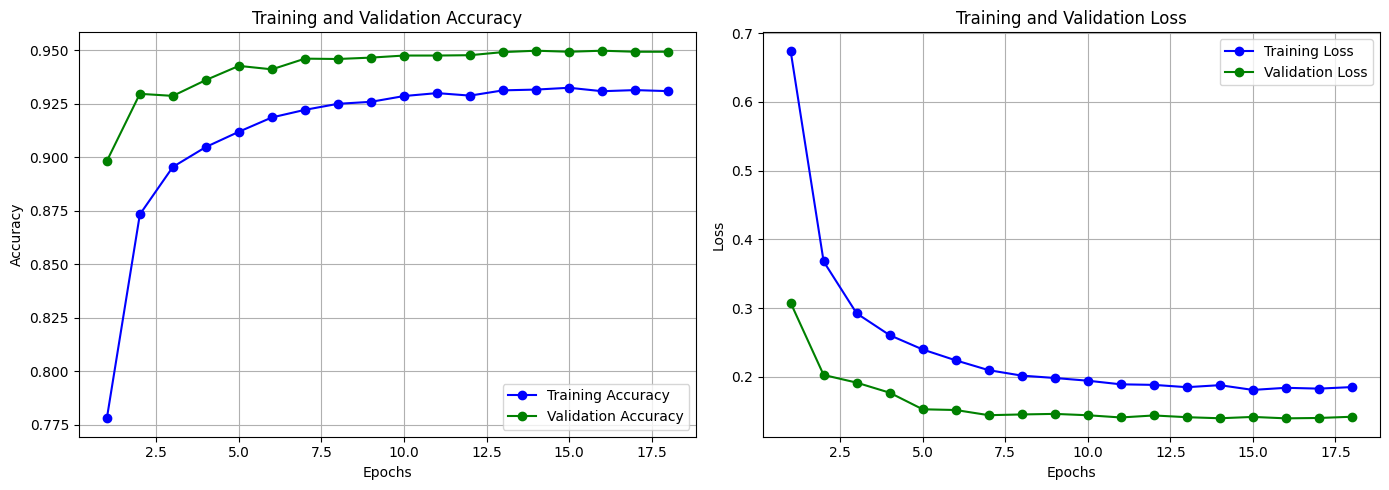

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)
